# 데모

## 라이브러리 import 및 설정

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings(action='ignore')

In [5]:
print(tf.__version__)

2.3.0


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU detected')

1 Physical GPUs, 1 Logical GPU


In [7]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## GloVe 임베딩 로드

http://nlp.stanford.edu/data/glove.6B.zip 를 다운받아 `data_dir`에 압축을 푼다.

In [8]:
data_dir = Path('./open')
feature_dir = Path('./build/feature')
val_dir = Path('./ensemble/build/val')
tst_dir = Path('./ensemble/build/tst')
sub_dir = Path('./open/sub')
dirs = [feature_dir, val_dir, tst_dir, sub_dir]
for d in dirs:
    os.makedirs(d, exist_ok=True)

trn_file = data_dir / 'train_processed_500.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'
glove_file = './dataset/glove.6B/glove.6B.100d.txt'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [9]:
algo_name = 'lstm'
feature_name = 'glove'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [10]:
embeddings_index = {}
with open(glove_file, encoding = 'UTF8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
        
print(f'Found {len(embeddings_index)} word vectors.')

Found 400001 word vectors.


## 학습데이터 로드

In [11]:
train = pd.read_csv(trn_file, index_col=0)
train.head()

,text,author,length
index,,,
0,He was almost choking. There was so much so mu...,3,235
1,Your sister asked for it I suppose,2,34
2,She was engaged one day as she walked in peru...,1,312
3,The captain was in the porch keeping himself c...,4,305
4,Have mercy gentlemen odin flung up his hands. ...,3,215


In [12]:
test = pd.read_csv(tst_file, index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


## Preprocessing

In [13]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)


stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "odin",
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [14]:
train['text'] = train['text'].str.lower().apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].str.lower().apply(alpha_num).apply(remove_stopwords)

In [15]:
train['length'] = train['text'].apply(len)

In [16]:
idx_under_20 = train[train['length'] < 20].index
train = train.drop(idx_under_20)
train = train.reset_index()
train.describe()

,index,author,length
count,166641.0000,166641.0000,166641.0000
mean,92005.6666,2.0459,104.6923
std,52938.5899,1.2939,109.3539
min,0.0000,0.0000,20.0000
25%,46306.0000,1.0000,44.0000
50%,92135.0000,2.0000,72.0000
75%,137863.0000,3.0000,119.0000
max,183467.0000,4.0000,1387.0000


In [17]:
train['length']= train['text'].apply(len)
train['text'].duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
166636     True
166637     True
166638     True
166639     True
166640     True
Name: text, Length: 166641, dtype: bool

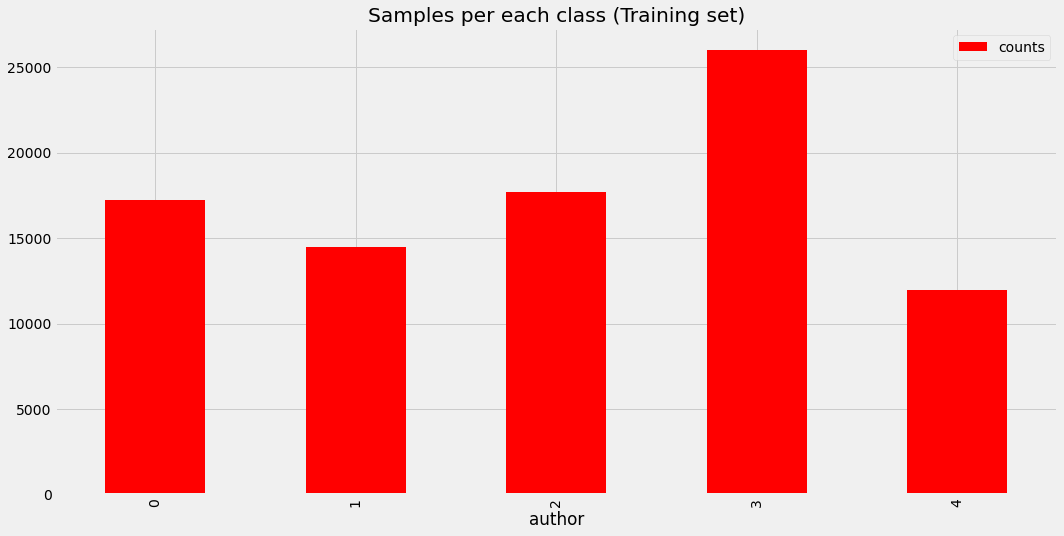

In [18]:
df = train.drop_duplicates(['text'])
df.groupby(df.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)",color='red')


In [19]:
df = df.reset_index()

In [20]:
df[df['length']>500].describe()
df=df.drop(columns='level_0')

In [21]:
df['index'] = df['index'].reset_index()

In [22]:
df

,index,text,author,length
0,0,almost choking much much wanted say strange ex...,3,129
1,1,sister asked suppose,2,20
2,2,engaged one day walked perusing janes last let...,1,191
3,3,captain porch keeping carefully way treacherou...,4,188
4,4,mercy gentlemen flung hands dont write anyway ...,3,123
...,...,...,...,...
87283,87283,though liberally provided friend funds sent be...,3,306
87284,87284,diningroom soon joined busily engaged separate...,1,73
87285,87285,one came books toilette,1,23
87286,87286,faces however tolerably calm no change visible...,1,138


In [23]:
train = df

In [24]:
trn = train['text'].values
tst = test['text'].values
y = train['author'].values
print(trn.shape, tst.shape, y.shape)

(87288,) (19617,) (87288,)


In [25]:
vectorizer = TextVectorization(max_tokens=100000, output_sequence_length=500)
text_ds = tf.data.Dataset.from_tensor_slices(trn).batch(128)
vectorizer.adapt(text_ds)

In [26]:
vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'not', 'said', 'no', 'one', 'mr', 'upon', 'will', 'now']

In [27]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [28]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words ({misses} misses)")

Converted 29888 words (17187 misses)


In [29]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False,
)

<h2> HyperOpt 하이퍼 파라미터 튜닝 

In [28]:
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from sklearn.model_selection import train_test_split


In [29]:
def data(batch_size, time_steps, trn, y):
    """
    function that returns data to be fed into objective function and model is trained on it subsequently.
    """
    BATCH_SIZE = batch_size
    TIME_STEPS = time_steps
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=.2, random_state=seed)
    return  X_trn, X_val, y_trn, y_val

In [30]:
search_space = {
    'batch_size': hp.choice('bs', [30,40,50,60,70]),
    'time_steps': hp.choice('ts', [30,50,60,80,90]),
    'embedding_dim' : 100,
    'vocab_size' : 10000,
    'lstm1_nodes': hp.choice('units_lsmt1', [64,80,100,128]),
    'lstm1_dropouts': hp.uniform('dos_lstm1',0,1),
    'lstm_layers': hp.choice('num_layers_lstm',[
        {
            'layers':'one', 
        },
        {
            'layers':'two',
            'lstm2_nodes': hp.choice('units_lstm2', [20,30,40,50]),
            'lstm2_dropouts': hp.uniform('dos_lstm2',0,1)  
        }
        ]),
    'dense_layers': hp.choice('num_layers_dense',[
        {
            'layers':'one'
        },
        {
            'layers':'two',
            'dense2_nodes': hp.choice('units_dense', [10,20,30,40])
        }
        ]),
    "lr": hp.loguniform('lr',np.log(0.01), np.log(0.2)),
    "epochs": 2,
    "optimizer": "Adam"
}

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

In [ ]:
def create_model_hypopt(params):
    """
    This method is called for each combination of parameter set to train the model and validate it against validation data
    to see all the results, from which best can be selected.
    """
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    # For most cases preparation of data can be done once and used 'n' number of times in this method to train the model
    # but in this case we want to find optimal value for batch_size and time_steps too. So our data preparation has to be done
    # based on that. Hence calling it from here.
    
    X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
    
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    int_sequences_input = Input(shape=(1,), dtype=tf.string)
    vectorized_sequences = vectorizer(int_sequences_input)
    embedded_sequences = embedding_layer(vectorized_sequences)
    x = Bidirectional(LSTM(params["lstm1_nodes"], 
                                dropout=params["lstm1_dropouts"],
                                #recurrent_dropout=params["lstm1_dropouts"], 
                                return_sequences=True,
                                kernel_initializer='random_uniform'))(embedded_sequences)
    if params["lstm_layers"]["layers"] == "two":
        x = Bidirectional(LSTM(params["lstm_layers"]["lstm2_nodes"], 
                 dropout=params["lstm_layers"]["lstm2_dropouts"]))(x)
    else:
        x = Flatten()(x)
    if params["dense_layers"]["layers"] == 'two':
        x = Dense(params["dense_layers"]["dense2_nodes"], activation='relu')(x)
    
    preds = Dense(n_class, activation="softmax")(x)
    model = Model(int_sequences_input, preds)


    lr = params["lr"]
    epochs = params["epochs"]
    optimizer = Adam(lr=lr)
    

    model.compile(loss='categorical_crossentropy', optimizer=optimizer)  # binary_crossentropy
    history = model.fit(X_trn, to_categorical(y_trn), epochs=epochs, verbose=1, batch_size=batch_size,
                             validation_data=[X_val, to_categorical(y_val)],
                             callbacks=[es])
    val_error = np.amin(history.history['val_loss']) 
    print('Best validation error of epoch:', val_error)
    return {'loss': val_error, 'status': STATUS_OK, 'model': model} # if accuracy use '-' sign
    # return history, lstm_model

# Trails object let's you return and store extra information from objective function, which
# can be analysed later. Check "trails.trails" which returns all the list of dictionaries 
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest, # type random.suggest to select param values randomly
    max_evals=20, # max number of evaluations you want to do on objective function
    trials=trials)

hyperparams = space_eval(search_space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

Trying params:                                        
{'batch_size': 50, 'dense_layers': {'layers': 'one'}, 'embedding_dim': 100, 'epochs': 2, 'lr': 0.028244642076466316, 'lstm1_dropouts': 0.0511448483682716, 'lstm1_nodes': 100, 'lstm_layers': {'layers': 'two', 'lstm2_dropouts': 0.31886551245575523, 'lstm2_nodes': 30}, 'optimizer': 'Adam', 'time_steps': 80, 'vocab_size': 10000}
Epoch 1/2                                             
   1/1397 [..............................]            
 - ETA: 0s - loss: 1.6222                             
                                                      
   2/1397 [..............................]            
 - ETA: 47s - loss: 1.8866                            
                                                     
   3/1397 [..............................]            
 - ETA: 1:05 - loss: 1.9742                           
                                                      
   4/1397 [..............................]            
 - ETA: 1:12 -

  48/1397 [>.............................]            
 - ETA: 1:28 - loss: 1.6341                           
                                                      
  49/1397 [>.............................]            
 - ETA: 1:28 - loss: 1.6330                           
                                                      
  50/1397 [>.............................]            
 - ETA: 1:28 - loss: 1.6324                           
                                                      
  51/1397 [>.............................]            
 - ETA: 1:28 - loss: 1.6327                           
                                                      
  52/1397 [>.............................]            
 - ETA: 1:28 - loss: 1.6316                           
                                                      
  53/1397 [>.............................]            
 - ETA: 1:28 - loss: 1.6307                           
                                                      
  54/1397 

 - ETA: 1:25 - loss: 1.6011                           
                                                      
  98/1397 [=>............................]            
 - ETA: 1:25 - loss: 1.6013                           
                                                      
  99/1397 [=>............................]            
 - ETA: 1:25 - loss: 1.6005                           
                                                      
 100/1397 [=>............................]            
 - ETA: 1:25 - loss: 1.6002                           
                                                      
 101/1397 [=>............................]            
 - ETA: 1:25 - loss: 1.6004                           
                                                      
 102/1397 [=>............................]            
 - ETA: 1:25 - loss: 1.5997                           
                                                      
 103/1397 [=>............................]            
 - ETA: 1:

                                                      
 147/1397 [==>...........................]            
 - ETA: 1:22 - loss: 1.5922                           
                                                      
 148/1397 [==>...........................]            
 - ETA: 1:22 - loss: 1.5916                           
                                                      
 149/1397 [==>...........................]            
 - ETA: 1:22 - loss: 1.5913                           
                                                      
 150/1397 [==>...........................]            
 - ETA: 1:22 - loss: 1.5910                           
                                                      
 151/1397 [==>...........................]            
 - ETA: 1:22 - loss: 1.5908                           
                                                      
 152/1397 [==>...........................]            
 - ETA: 1:22 - loss: 1.5910                           
          

 196/1397 [===>..........................]            
 - ETA: 1:19 - loss: 1.5869                           
                                                      
 197/1397 [===>..........................]            
 - ETA: 1:18 - loss: 1.5870                           
                                                      
 198/1397 [===>..........................]            
 - ETA: 1:18 - loss: 1.5868                           
                                                      
 199/1397 [===>..........................]            
 - ETA: 1:18 - loss: 1.5864                           
                                                      
 200/1397 [===>..........................]            
 - ETA: 1:18 - loss: 1.5860                           
                                                      
 201/1397 [===>..........................]            
 - ETA: 1:18 - loss: 1.5861                           
                                                      
 202/1397 

 - ETA: 1:15 - loss: 1.5827                           
                                                      
 246/1397 [====>.........................]            
 - ETA: 1:15 - loss: 1.5825                           
                                                      
 247/1397 [====>.........................]            
 - ETA: 1:15 - loss: 1.5824                           
                                                      
 248/1397 [====>.........................]            
 - ETA: 1:15 - loss: 1.5826                           
                                                      
 249/1397 [====>.........................]            
 - ETA: 1:15 - loss: 1.5826                           
                                                      
 250/1397 [====>.........................]            
 - ETA: 1:15 - loss: 1.5826                           
                                                      
 251/1397 [====>.........................]            
 - ETA: 1:

                                                      
 295/1397 [=====>........................]            
 - ETA: 1:12 - loss: 1.5819                           
                                                      
 296/1397 [=====>........................]            
 - ETA: 1:12 - loss: 1.5815                           
                                                      
 297/1397 [=====>........................]            
 - ETA: 1:12 - loss: 1.5816                           
                                                      
 298/1397 [=====>........................]            
 - ETA: 1:12 - loss: 1.5816                           
                                                      
 299/1397 [=====>........................]            
 - ETA: 1:12 - loss: 1.5816                           
                                                      
 300/1397 [=====>........................]            
 - ETA: 1:12 - loss: 1.5815                           
          

 344/1397 [======>.......................]            
 - ETA: 1:09 - loss: 1.5807                           
                                                      
 345/1397 [======>.......................]            
 - ETA: 1:09 - loss: 1.5809                           
                                                      
 346/1397 [======>.......................]            
 - ETA: 1:09 - loss: 1.5808                           
                                                      
 347/1397 [======>.......................]            
 - ETA: 1:09 - loss: 1.5808                           
                                                      
 348/1397 [======>.......................]            
 - ETA: 1:09 - loss: 1.5807                           
                                                      
 349/1397 [======>.......................]            
 - ETA: 1:08 - loss: 1.5806                           
                                                      
 350/1397 

 - ETA: 1:06 - loss: 1.5803                           
                                                      
 394/1397 [=======>......................]            
 - ETA: 1:06 - loss: 1.5800                           
                                                      
 395/1397 [=======>......................]            
 - ETA: 1:05 - loss: 1.5799                           
                                                      
 396/1397 [=======>......................]            
 - ETA: 1:05 - loss: 1.5797                           
                                                      
 397/1397 [=======>......................]            
 - ETA: 1:05 - loss: 1.5795                           
                                                      
 398/1397 [=======>......................]            
 - ETA: 1:05 - loss: 1.5796                           
                                                      
 399/1397 [=======>......................]            
 - ETA: 1:

                                                      
 443/1397 [========>.....................]            
 - ETA: 1:02 - loss: 1.5775                           
                                                      
 444/1397 [========>.....................]            
 - ETA: 1:02 - loss: 1.5774                           
                                                      
 445/1397 [========>.....................]            
 - ETA: 1:02 - loss: 1.5772                           
                                                      
 446/1397 [========>.....................]            
 - ETA: 1:02 - loss: 1.5774                           
                                                      
 447/1397 [========>.....................]            
 - ETA: 1:02 - loss: 1.5775                           
                                                      
 448/1397 [========>.....................]            
 - ETA: 1:02 - loss: 1.5774                           
          

 - ETA: 59s - loss: 1.5759                            
                                                     
 493/1397 [=========>....................]            
 - ETA: 59s - loss: 1.5759                            
                                                     
 494/1397 [=========>....................]            
 - ETA: 59s - loss: 1.5759                            
                                                     
 495/1397 [=========>....................]            
 - ETA: 59s - loss: 1.5758                            
                                                     
 496/1397 [=========>....................]            
 - ETA: 59s - loss: 1.5757                            
                                                     
 497/1397 [=========>....................]            
 - ETA: 59s - loss: 1.5756                            
                                                     
 498/1397 [=========>....................]            
 - ETA: 59s - lo

 542/1397 [==========>...................]            
 - ETA: 56s - loss: 1.5744                            
                                                     
 543/1397 [==========>...................]            
 - ETA: 56s - loss: 1.5742                            
                                                     
 544/1397 [==========>...................]            
 - ETA: 56s - loss: 1.5743                            
                                                     
 545/1397 [==========>...................]            
 - ETA: 56s - loss: 1.5744                            
                                                     
 546/1397 [==========>...................]            
 - ETA: 56s - loss: 1.5744                            
                                                     
 547/1397 [==========>...................]            
 - ETA: 56s - loss: 1.5744                            
                                                     
 548/1397 [=====

                                                     
 592/1397 [===========>..................]            
 - ETA: 53s - loss: 1.5721                            
                                                     
 593/1397 [===========>..................]            
 - ETA: 53s - loss: 1.5721                            
                                                     
 594/1397 [===========>..................]            
 - ETA: 53s - loss: 1.5722                            
                                                     
 595/1397 [===========>..................]            
 - ETA: 53s - loss: 1.5723                            
                                                     
 596/1397 [===========>..................]            
 - ETA: 53s - loss: 1.5722                            
                                                     
 597/1397 [===========>..................]            
 - ETA: 53s - loss: 1.5722                            
                

In [2]:
params

NameError: name 'params' is not defined

## Training

In [30]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [31]:
batch_size = 256
n_timesteps = 40
n_features = 40
def get_model():
    int_sequences_input = Input(shape=(1,), dtype=tf.string)
    vectorized_sequences = vectorizer(int_sequences_input)
    embedded_sequences = embedding_layer(vectorized_sequences)
    x = Bidirectional(LSTM(128, dropout=0.2, batch_input_shape=(batch_size, n_timesteps, n_features), return_sequences=True))(embedded_sequences)
    x = Bidirectional(LSTM(128, dropout=0.2, return_sequences=True))(x)
    x = Bidirectional(LSTM(128, dropout=0.2,))(x)
    x = Dense(64,activation ="relu")(x)
    preds = Dense(n_class, activation="softmax")(x)
    model = Model(int_sequences_input, preds)
    
    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=.01))
    return model

In [ ]:
def get_model_hypopt(params):
    """
    This method is called for each combination of parameter set to train the model and validate it against validation data
    to see all the results, from which best can be selected.
    """
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    # For most cases preparation of data can be done once and used 'n' number of times in this method to train the model
    # but in this case we want to find optimal value for batch_size and time_steps too. So our data preparation has to be done
    # based on that. Hence calling it from here.
        
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    int_sequences_input = Input(shape=(1,), dtype=tf.string)
    vectorized_sequences = vectorizer(int_sequences_input)
    embedded_sequences = embedding_layer(vectorized_sequences)
    x = Bidirectional(LSTM(params["lstm1_nodes"], 
                                dropout=params["lstm1_dropouts"],
                                #recurrent_dropout=params["lstm1_dropouts"], 
                                return_sequences=True,
                                kernel_initializer='random_uniform'))(embedded_sequences)
    if params["lstm_layers"]["layers"] == "two":
        x = Bidirectional(LSTM(params["lstm_layers"]["lstm2_nodes"], 
                 dropout=params["lstm_layers"]["lstm2_dropouts"]))(x)
    else:
        x = Flatten()(x)
    if params["dense_layers"]["layers"] == 'two':
        x = Dense(params["dense_layers"]["dense2_nodes"], activation='relu')(x)
    
    preds = Dense(n_class, activation="softmax")(x)
    model = Model(int_sequences_input, preds)
    lr = params["lr"]
    epochs = params["epochs"]
    optimizer = Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)  # binary_crossentropy
    
    return model

In [32]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)
    
    clf = get_model() 
    clf.fit(trn[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(trn[i_val], to_categorical(y[i_val])),
            epochs=20,
            batch_size=batch_size,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold
    del(clf)
    gc.collect()
    tf.keras.backend.clear_session()

training model for CV #1
Epoch 1/20
  4/273 [..............................] - ETA: 56s - loss: 1.6644

InternalError:    Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 100, 128, 1, 500, 256, 128] 
	 [[{{node CudnnRNN}}]]
	 [[functional_1/bidirectional/forward_lstm/PartitionedCall]] [Op:__inference_train_function_18811]

Function call stack:
train_function -> train_function -> train_function


In [ ]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

In [ ]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 시각화

In [ ]:
clf.summary()

In [ ]:
plot_model(clf)

## 제출 파일 생성

In [ ]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

In [ ]:
sub[sub.columns] = p_tst
sub.head()

In [ ]:
sub.to_csv(sub_file)